In [1]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score

In [2]:
random.seed(42)

no_sepsis_path = "sepsis_dataset-2/dataset/no_sepsis"
sepsis_path = "sepsis_dataset-2/dataset/sepsis"
num_files_to_pick = 225

def select_random_files(folder_path, num_files):
    files = os.listdir(folder_path)
    selected_files = random.sample(files, num_files)
    return [os.path.join(folder_path, file) for file in selected_files]

In [3]:
selected_no_sepsis = select_random_files(no_sepsis_path, num_files_to_pick)
selected_sepsis = select_random_files(sepsis_path, num_files_to_pick)

selected_files = selected_no_sepsis + selected_sepsis

print(f"Selected {len(selected_no_sepsis)} 'no_sepsis' files and {len(selected_sepsis)} 'sepsis' files.")

Selected 225 'no_sepsis' files and 225 'sepsis' files.


In [4]:
selected_no_sepsis

['sepsis_dataset-2/dataset/no_sepsis\\688.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\200.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\120.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\782.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\351.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\323.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\303.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\226.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\778.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\192.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\721.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\781.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\920.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\600.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\179.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\642.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\488.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\127.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\125.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\184.csv',
 'sepsis_dataset-2/dataset/no_sepsis\\3.

In [5]:
def load_and_merge_csv(file_list):
    data_frames = []
    for file in file_list:
        df = pd.read_csv(file)
        data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)

In [6]:
merged_data = load_and_merge_csv(selected_files)

print(f"Merged data shape: {merged_data.shape}")

Merged data shape: (10800, 27)


In [7]:
merged_data.head()

,heart_rate,bp_systolic,bp_diastolic,map,resp,temp,spo2,fio2,wbc,bun,...,bicarbonate,hemoglobin,hematocrit,potassium,chloride,gcs,age,sirs,qsofa,sepsis_icd
0,85.0,122.0,59.0,74.0,29.0,35.500000,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,62.84,1.0,0.0,0.0
1,88.0,110.0,57.0,70.0,21.0,35.500000,99.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,62.84,1.0,0.0,0.0
2,91.0,110.0,60.0,72.0,20.0,36.277778,99.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,62.84,0.0,0.0,0.0
3,97.0,114.0,51.0,65.0,19.0,36.277778,99.0,NaN,13.2,12.0,...,28.0,11.3,32.5,3.7,88.0,15.0,62.84,1.0,0.0,0.0
4,99.0,90.0,50.0,61.0,18.0,36.277778,96.0,NaN,13.2,12.0,...,28.0,11.3,32.5,3.7,88.0,15.0,62.84,1.0,0.0,0.0


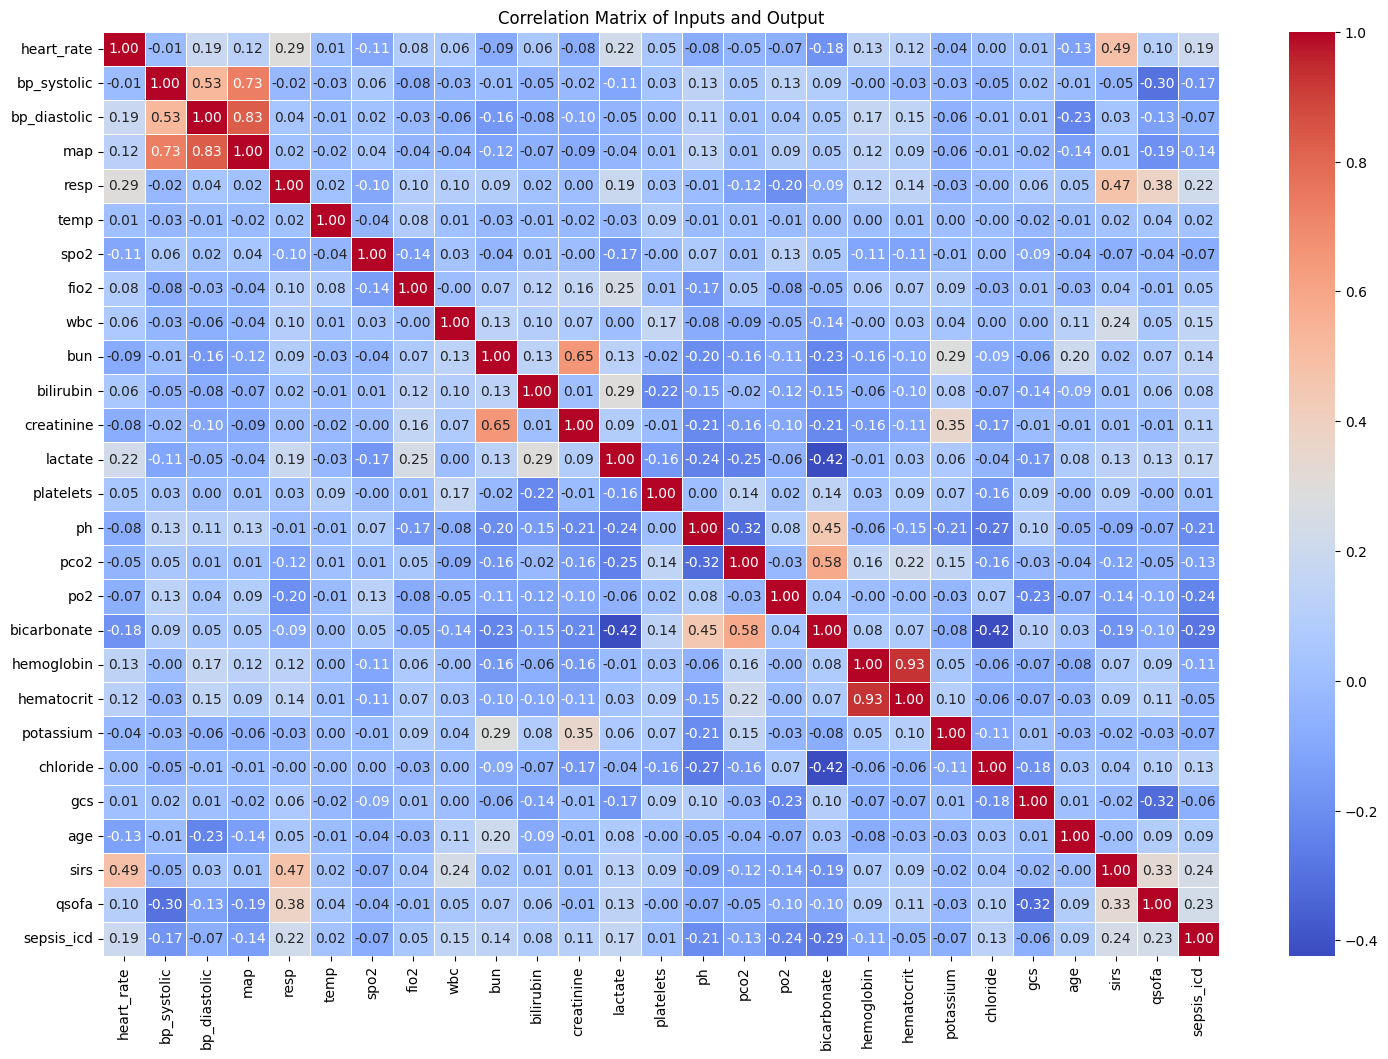

In [8]:
correlation_matrix = merged_data.corr()

# Plotting the correlation matrix heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Inputs and Output")
plt.show()

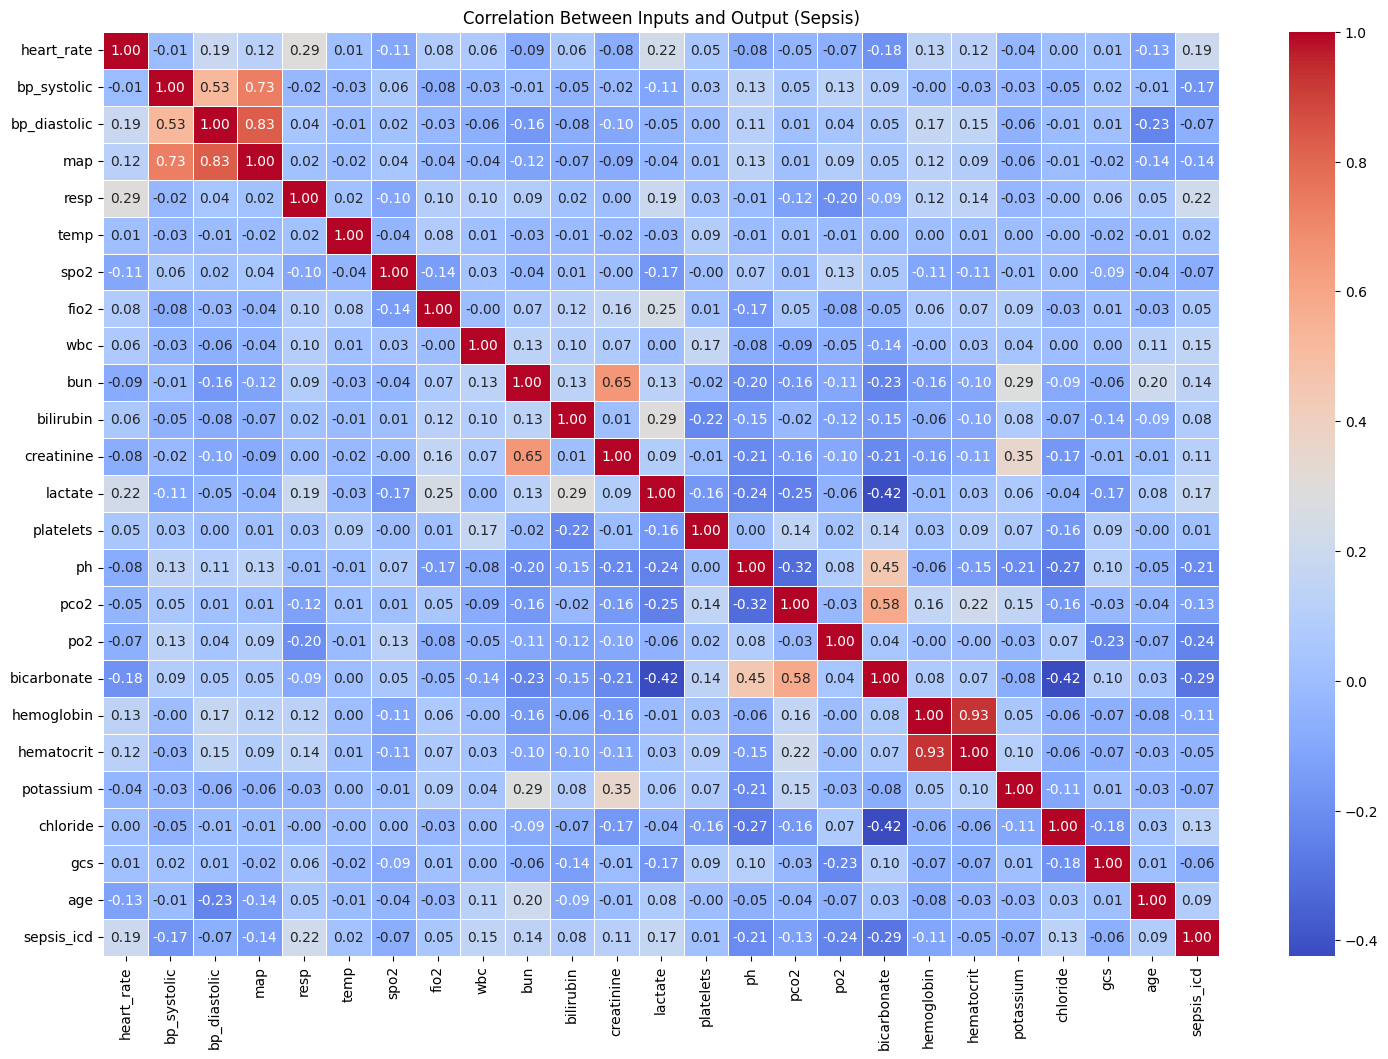

In [9]:
input_columns = ["heart_rate", "bp_systolic", "bp_diastolic", "map", "resp", "temp", "spo2", "fio2", "wbc", "bun", "bilirubin", "creatinine", "lactate", "platelets", "ph", "pco2", "po2", "bicarbonate", "hemoglobin", "hematocrit", "potassium", "chloride", "gcs", "age"]
output_column = 'sepsis_icd'

input_output_corr = merged_data[input_columns + [output_column]].corr()

plt.figure(figsize=(18, 12))
sns.heatmap(input_output_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Between Inputs and Output (Sepsis)")
plt.show()

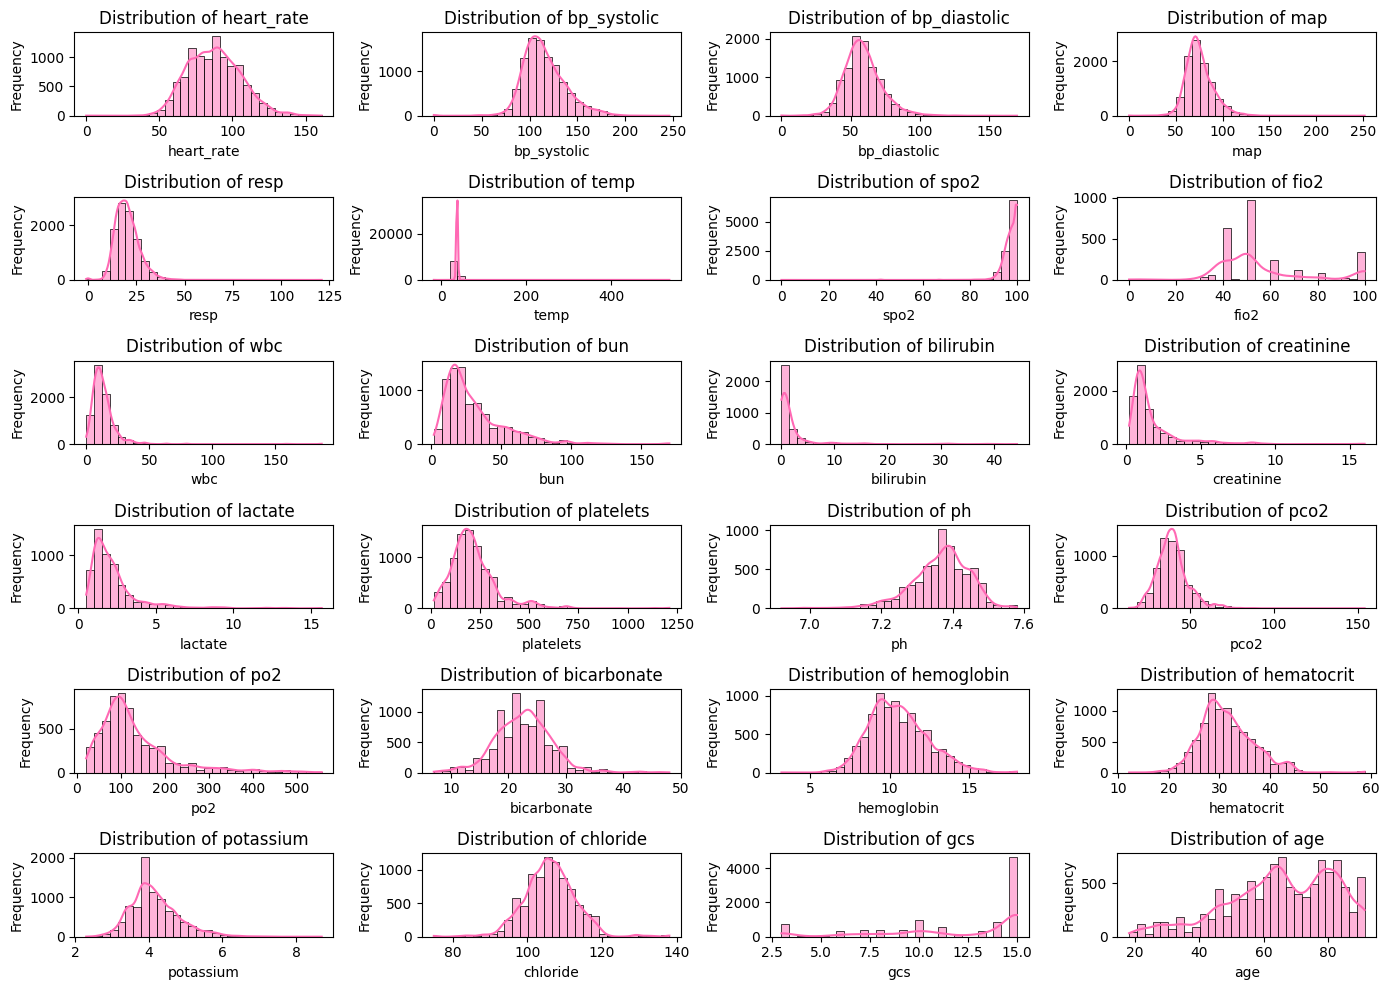

In [10]:
plt.figure(figsize=(14, 10))
for i, column in enumerate(input_columns, 1):
    plt.subplot(6, 4, i)
    sns.histplot(merged_data[column], kde=True, color='hotpink', bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

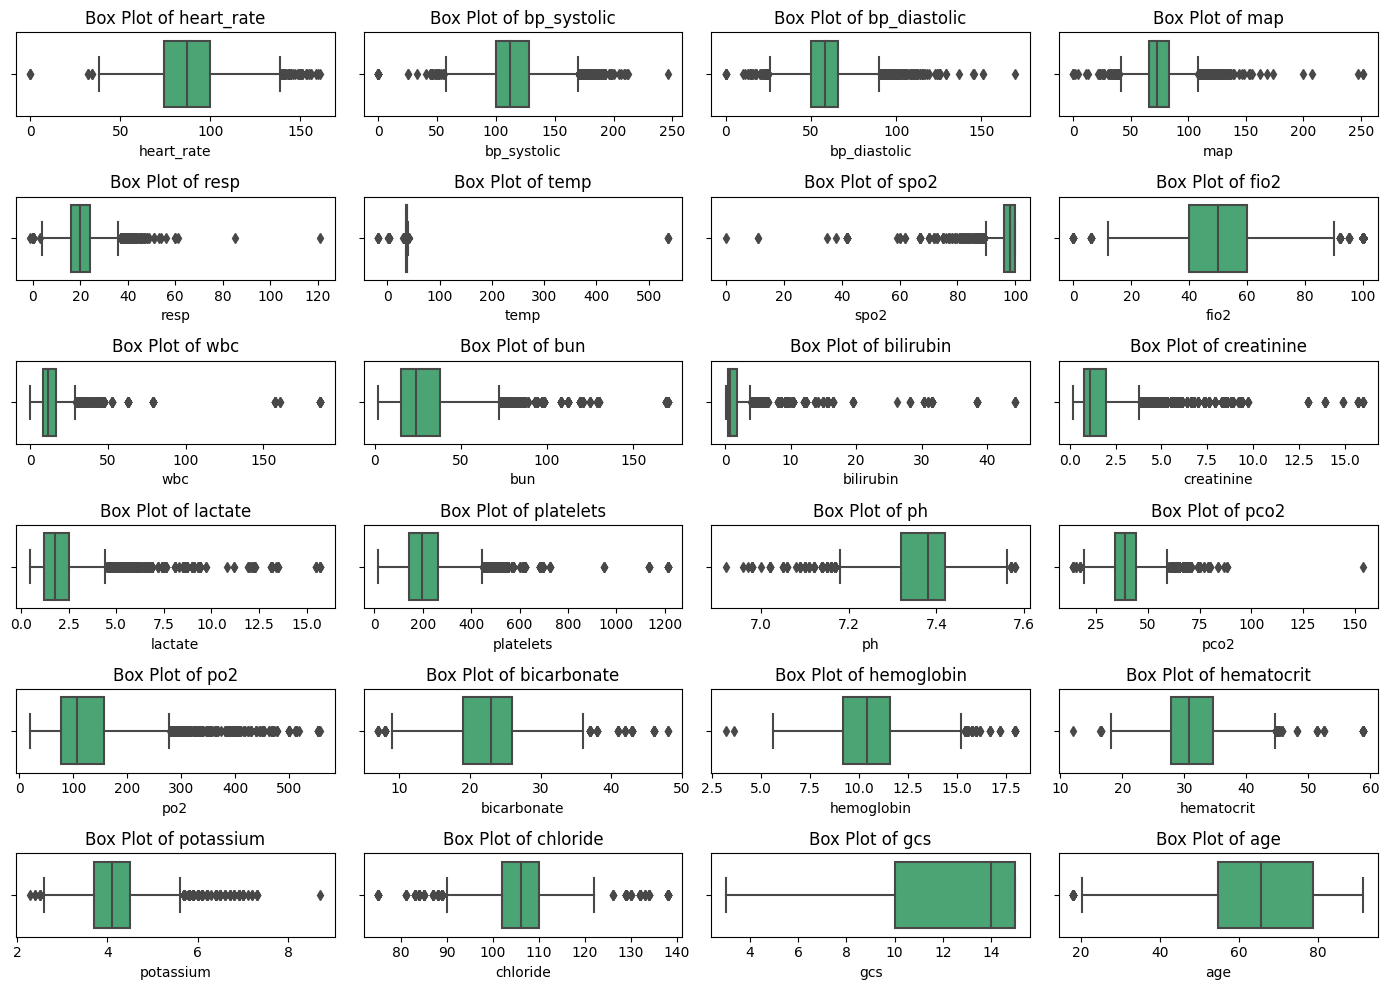

In [11]:
plt.figure(figsize=(14, 10))
for i, column in enumerate(input_columns, 1):
    plt.subplot(6,4, i)
    sns.boxplot(x=merged_data[column], color='mediumseagreen')
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

In [12]:
stats = merged_data[input_columns].agg(['min', 'max', 'std']).transpose()
stats.columns = ['Min', 'Max', 'Standard Deviation']

print("Statistical Summary of Parameters:")
print(stats)

# Count the number of positive (sepsis=1) and negative (sepsis=0) instances
positive_instances = merged_data[merged_data['sepsis_icd'] == 1].shape[0]
negative_instances = merged_data[merged_data['sepsis_icd'] == 0].shape[0]

print("\nNumber of Positive and Negative Instances:")
print(f"Positive Instances (Sepsis=1): {positive_instances}")
print(f"Negative Instances (Sepsis=0): {negative_instances}")

Statistical Summary of Parameters:
                    Min          Max  Standard Deviation
heart_rate     0.000000   161.000000           18.167605
bp_systolic    0.000000   246.000000           22.138305
bp_diastolic   0.000000   170.000000           13.769759
map            0.000000   252.000000           15.060348
resp          -1.000000   121.000000            6.232051
temp         -17.777778   536.388889           10.215418
spo2           0.000000   100.000000            4.141036
fio2           0.000000   100.000000           20.851160
wbc            0.100000   186.600000           11.875305
bun            2.000000   170.000000           22.068659
bilirubin      0.100000    44.300000            4.690792
creatinine     0.200000    16.000000            1.849112
lactate        0.500000    15.700000            1.695153
platelets     16.000000  1212.000000          122.221767
ph             6.920000     7.580000            0.080818
pco2          14.000000   154.000000            9.355

In [13]:
missing_values = merged_data.isnull().sum()
print(missing_values[missing_values > 0])


heart_rate       535
bp_systolic      540
bp_diastolic     540
map              551
resp             525
temp             856
spo2             610
fio2            8213
wbc             2580
bun             2410
bilirubin       7292
creatinine      2399
lactate         5377
platelets       2448
ph              4559
pco2            4795
po2             4795
bicarbonate     2441
hemoglobin      2407
hematocrit      2284
potassium       2083
chloride        2264
gcs              950
age              301
sirs             301
qsofa            301
sepsis_icd       301
dtype: int64


In [14]:
critical_columns = ['sirs', 'qsofa', 'sepsis_icd']
merged_data = merged_data.dropna(subset=critical_columns)
print(f"Data shape after dropping rows with null critical columns: {merged_data.shape}")
print(merged_data.isnull().sum())

Data shape after dropping rows with null critical columns: (10499, 27)
heart_rate       234
bp_systolic      239
bp_diastolic     239
map              250
resp             224
temp             555
spo2             309
fio2            7912
wbc             2279
bun             2109
bilirubin       6991
creatinine      2098
lactate         5076
platelets       2147
ph              4258
pco2            4494
po2             4494
bicarbonate     2140
hemoglobin      2106
hematocrit      1983
potassium       1782
chloride        1963
gcs              649
age                0
sirs               0
qsofa              0
sepsis_icd         0
dtype: int64


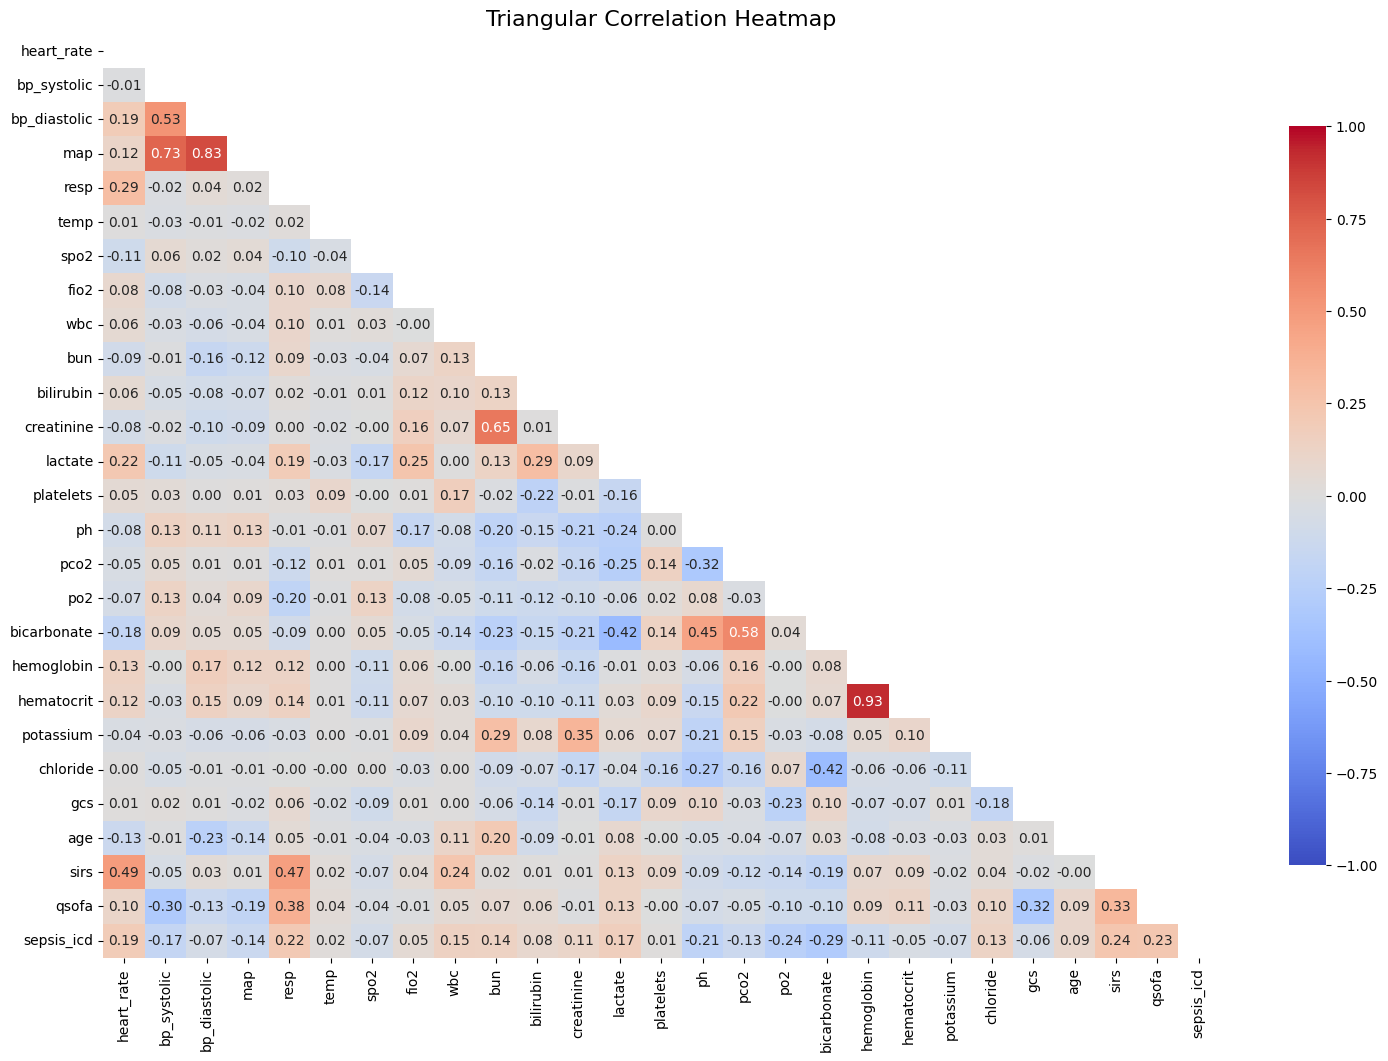

In [15]:
correlation_matrix = merged_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(18, 12))

sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    cmap="coolwarm", 
    annot=True, 
    fmt=".2f", 
    cbar_kws={"shrink": .8},
    vmin=-1, 
    vmax=1
)

plt.title("Triangular Correlation Heatmap", fontsize=16)
plt.show()

In [16]:
# Columns with <20% missing values
low_missing_cols = merged_data.columns[merged_data.isnull().mean() < 0.2]
low_missing_cols

Index(['heart_rate', 'bp_systolic', 'bp_diastolic', 'map', 'resp', 'temp',
       'spo2', 'creatinine', 'hematocrit', 'potassium', 'chloride', 'gcs',
       'age', 'sirs', 'qsofa', 'sepsis_icd'],
      dtype='object')

In [17]:
for col in low_missing_cols:
    #if merged_data[col].dtype in ['float64', 'int64']:
    merged_data[col].fillna(merged_data[col].median(), inplace=True)
    #else:
     #   merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)

# Drop high missingness columns (>50%)
high_missing_cols = merged_data.columns[merged_data.isnull().mean() > 0.4]
print(high_missing_cols)
merged_data.drop(columns=high_missing_cols, inplace=True)

# Verify remaining nulls and columns
print("Remaining null values:")
print(merged_data.isnull().sum())
print("\nRemaining columns:")
print(merged_data.columns)

Index(['fio2', 'bilirubin', 'lactate', 'ph', 'pco2', 'po2'], dtype='object')
Remaining null values:
heart_rate         0
bp_systolic        0
bp_diastolic       0
map                0
resp               0
temp               0
spo2               0
wbc             2279
bun             2109
creatinine         0
platelets       2147
bicarbonate     2140
hemoglobin      2106
hematocrit         0
potassium          0
chloride           0
gcs                0
age                0
sirs               0
qsofa              0
sepsis_icd         0
dtype: int64

Remaining columns:
Index(['heart_rate', 'bp_systolic', 'bp_diastolic', 'map', 'resp', 'temp',
       'spo2', 'wbc', 'bun', 'creatinine', 'platelets', 'bicarbonate',
       'hemoglobin', 'hematocrit', 'potassium', 'chloride', 'gcs', 'age',
       'sirs', 'qsofa', 'sepsis_icd'],
      dtype='object')


In [18]:
moderate_missing_cols = ['wbc', 'bun', 'platelets', 'bicarbonate', 'hemoglobin']
for col in moderate_missing_cols:
    merged_data[col].fillna(merged_data[col].median(), inplace=True)

# Verify final dataset
print("Remaining null values:")
print(merged_data.isnull().sum())
print("\nFinal columns:")
print(merged_data.columns)

Remaining null values:
heart_rate      0
bp_systolic     0
bp_diastolic    0
map             0
resp            0
temp            0
spo2            0
wbc             0
bun             0
creatinine      0
platelets       0
bicarbonate     0
hemoglobin      0
hematocrit      0
potassium       0
chloride        0
gcs             0
age             0
sirs            0
qsofa           0
sepsis_icd      0
dtype: int64

Final columns:
Index(['heart_rate', 'bp_systolic', 'bp_diastolic', 'map', 'resp', 'temp',
       'spo2', 'wbc', 'bun', 'creatinine', 'platelets', 'bicarbonate',
       'hemoglobin', 'hematocrit', 'potassium', 'chloride', 'gcs', 'age',
       'sirs', 'qsofa', 'sepsis_icd'],
      dtype='object')


In [19]:
correlation_matrix = merged_data.corr()

# Get the correlation of each feature with the target variable 'sepsis_icd'
correlation_with_target = correlation_matrix['sepsis_icd'].sort_values(ascending=False)

# Print the correlation with the target variable
print(correlation_with_target)

sepsis_icd      1.000000
sirs            0.239662
qsofa           0.230517
resp            0.214019
heart_rate      0.192664
wbc             0.135054
bun             0.127438
chloride        0.119014
creatinine      0.103362
age             0.090997
temp            0.021588
platelets       0.013908
hematocrit     -0.040067
gcs            -0.064524
potassium      -0.065144
bp_diastolic   -0.066262
spo2           -0.073557
hemoglobin     -0.099196
map            -0.132947
bp_systolic    -0.170945
bicarbonate    -0.259871
Name: sepsis_icd, dtype: float64


In [20]:
# Set a threshold for feature selection (e.g., correlation > 0.1 or < -0.1)
threshold = 0.15

# Select features with a high correlation with the target (positive or negative)
selected_features = correlation_with_target[abs(correlation_with_target) > threshold].index.tolist()

# Display the selected features
print("\nSelected features based on correlation with target:")
print(selected_features)


Selected features based on correlation with target:
['sepsis_icd', 'sirs', 'qsofa', 'resp', 'heart_rate', 'bp_systolic', 'bicarbonate']


In [21]:
# Create a new dataset with only the selected features
selected_data = merged_data[selected_features]

# Check the shape of the selected dataset
print("\nShape of the dataset with selected features:")
print(selected_data.shape)


Shape of the dataset with selected features:
(10499, 7)


In [22]:
correlation_matrix_filtered = selected_data.corr()
correlation_with_target = correlation_matrix_filtered['sepsis_icd'].sort_values(ascending=False)
print(correlation_with_target)

sepsis_icd     1.000000
sirs           0.239662
qsofa          0.230517
resp           0.214019
heart_rate     0.192664
bp_systolic   -0.170945
bicarbonate   -0.259871
Name: sepsis_icd, dtype: float64


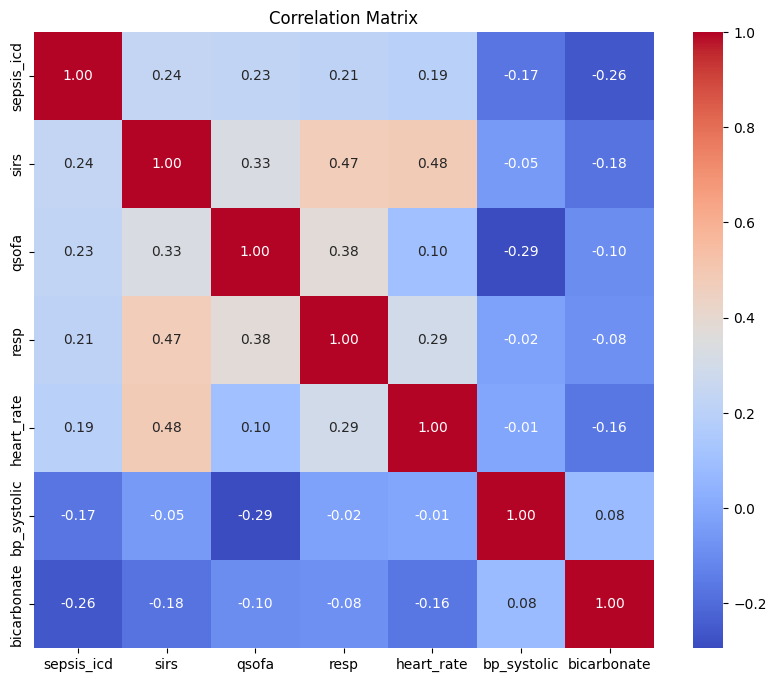

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [24]:
#!pip install scikit-fuzzy

In [25]:
selected_data['heart_rate'].mean()

87.62710734355653

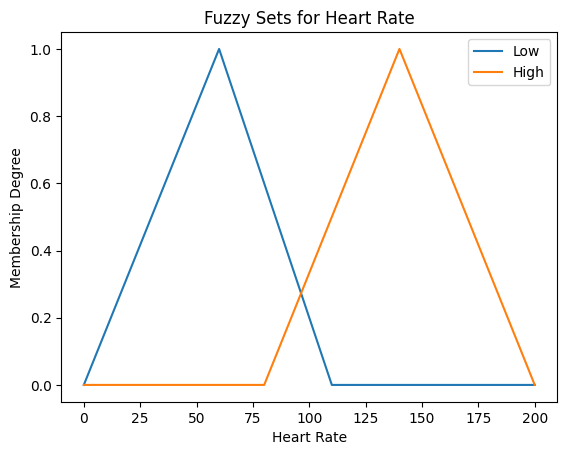

In [26]:
heart_rate = np.arange(0, 201, 1)

low_heart_rate = fuzz.trimf(heart_rate, [0, 60, 110])
high_heart_rate = fuzz.trimf(heart_rate, [80, 140, 200])

plt.plot(heart_rate, low_heart_rate, label="Low")
plt.plot(heart_rate, high_heart_rate, label="High")
plt.title("Fuzzy Sets for Heart Rate")
plt.xlabel("Heart Rate")
plt.ylabel("Membership Degree")
plt.legend()
plt.show()

In [27]:
selected_data['resp'].mean()

20.21754452805029

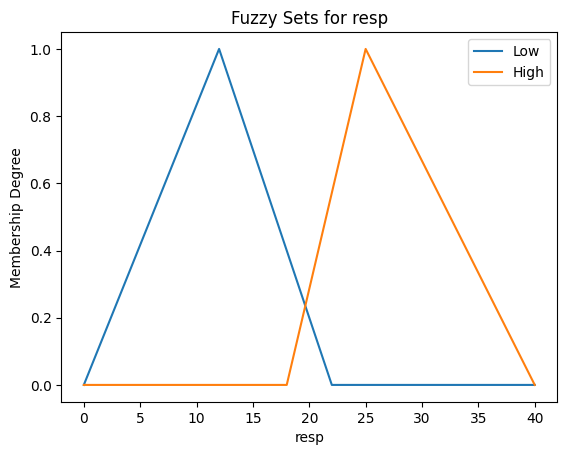

In [28]:
resp = np.arange(0, 41, 1)
low_resp = fuzz.trimf(resp, [0, 12, 22])
high_resp = fuzz.trimf(resp, [18, 25, 40])

plt.plot(resp, low_resp, label="Low")
plt.plot(resp, high_resp, label="High")
plt.title("Fuzzy Sets for resp")
plt.xlabel("resp")
plt.ylabel("Membership Degree")
plt.legend()
plt.show()

In [29]:
selected_data['bp_systolic'].mean()

115.1664920468616

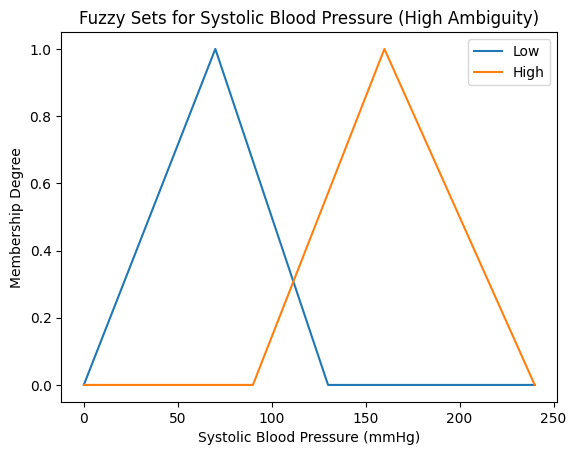

In [30]:
bp_systolic = np.arange(0, 241, 1)

low_bp_systolic = fuzz.trimf(bp_systolic, [0, 70, 130])
high_bp_systolic = fuzz.trimf(bp_systolic, [90, 160, 240])

plt.plot(bp_systolic, low_bp_systolic, label="Low")
plt.plot(bp_systolic, high_bp_systolic, label="High")
plt.title("Fuzzy Sets for Systolic Blood Pressure (High Ambiguity)")
plt.xlabel("Systolic Blood Pressure (mmHg)")
plt.ylabel("Membership Degree")
plt.legend()
plt.show()

In [31]:
selected_data['bicarbonate'].mean()

22.65684350890561

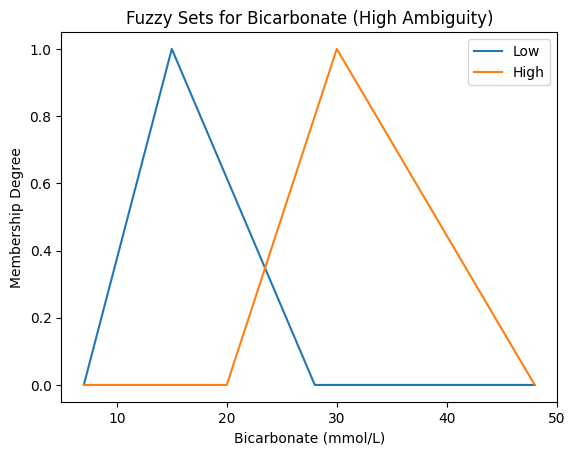

In [32]:
bicarbonate = np.arange(7, 49, 1)

low_bicarbonate = fuzz.trimf(bicarbonate, [7, 15, 28])
high_bicarbonate = fuzz.trimf(bicarbonate, [20, 30, 48])

plt.plot(bicarbonate, low_bicarbonate, label="Low")
plt.plot(bicarbonate, high_bicarbonate, label="High")
plt.title("Fuzzy Sets for Bicarbonate (High Ambiguity)")
plt.xlabel("Bicarbonate (mmol/L)")
plt.ylabel("Membership Degree")
plt.legend()
plt.show()

In [33]:
heart_rate = ctrl.Antecedent(np.arange(40, 201, 1), 'heart_rate')
resp = ctrl.Antecedent(np.arange(10, 31, 1), 'resp')
bicarbonate = ctrl.Antecedent(np.arange(10, 41, 1), 'bicarbonate')
bp_systolic = ctrl.Antecedent(np.arange(50, 181, 1), 'bp_systolic')

In [34]:
heart_rate['low'] = fuzz.trimf(heart_rate.universe, [0, 60, 110])
heart_rate['high'] = fuzz.trimf(heart_rate.universe, [80, 140, 200])

resp['low'] = fuzz.trimf(resp.universe, [0, 12, 22])
resp['high'] = fuzz.trimf(resp.universe, [18, 25, 40])

bicarbonate['low'] = fuzz.trimf(bicarbonate.universe, [7, 15, 28])
bicarbonate['high'] = fuzz.trimf(bicarbonate.universe, [20, 30, 48])

bp_systolic['low'] = fuzz.trimf(bp_systolic.universe, [0, 70, 130])
bp_systolic['high'] = fuzz.trimf(bp_systolic.universe, [90, 160, 240])


In [35]:
sepsis = ctrl.Consequent(np.arange(0, 2, 1), 'sepsis')
sepsis['no'] = fuzz.trimf(sepsis.universe, [0, 0, 1])
sepsis['yes'] = fuzz.trimf(sepsis.universe, [0, 1, 1])

In [36]:
rule1 = ctrl.Rule(resp['high'] | heart_rate['high'], sepsis['yes'])
rule2 = ctrl.Rule(bicarbonate['high'] | bp_systolic['high'], sepsis['no'])
rule3 = ctrl.Rule(resp['low'] | heart_rate['low'], sepsis['no'])
rule4 = ctrl.Rule(bp_systolic['low'] | bicarbonate['low'], sepsis['yes'])

In [37]:
sepsis_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
sepsis_simulation = ctrl.ControlSystemSimulation(sepsis_control)

In [38]:
selected_data['predicted_sepsis'] = 0
selected_data['predicted_score'] = 0.0

C:\Users\zgebl\AppData\Local\Temp\ipykernel_8256\2217440563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['predicted_sepsis'] = 0
C:\Users\zgebl\AppData\Local\Temp\ipykernel_8256\2217440563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['predicted_score'] = 0.0


In [39]:
for idx, row in selected_data.iterrows():
    sepsis_simulation.input['resp'] = row['resp']
    sepsis_simulation.input['heart_rate'] = row['heart_rate']
    sepsis_simulation.input['bp_systolic'] = row['bp_systolic']
    sepsis_simulation.input['bicarbonate'] = row['bicarbonate']
    sepsis_simulation.compute()
    selected_data.at[idx, 'predicted_score'] = sepsis_simulation.output.get('sepsis', 0)
    selected_data.at[idx, 'predicted_sepsis'] = 1 if sepsis_simulation.output.get('sepsis', 0) >= 0.5 else 0

predicted_score = sepsis_simulation.output.get('sepsis', 0)

In [40]:
selected_data

,sepsis_icd,sirs,qsofa,resp,heart_rate,bp_systolic,bicarbonate,predicted_sepsis,predicted_score
0,0.0,1.0,0.0,29.0,85.0,122.0,23.0,1,0.545890
1,0.0,1.0,0.0,21.0,88.0,110.0,23.0,0,0.497969
2,0.0,0.0,0.0,20.0,91.0,110.0,23.0,1,0.500860
3,0.0,1.0,0.0,19.0,97.0,114.0,28.0,0,0.417189
4,0.0,1.0,0.0,18.0,99.0,90.0,28.0,0,0.479073
...,...,...,...,...,...,...,...,...,...
10795,1.0,0.0,0.0,15.0,65.0,113.0,18.0,0,0.483505
10796,1.0,0.0,0.0,15.0,63.0,100.0,18.0,0,0.479591
10797,1.0,0.0,0.0,15.0,65.0,99.0,18.0,0,0.483505
10798,1.0,0.0,0.0,20.0,67.0,120.0,18.0,0,0.487964


Confusion Matrix:
[[3729 1522]
 [2319 2929]]
TPR (Sensitivity): 0.56
FPR (Fall-out): 0.29
TNR (Specificity): 0.71
FNR (Miss Rate): 0.44
Accuracy: 0.63
Precision: 0.66
Recall (Sensitivity/TPR): 0.56
F1 Score: 0.60
ROC AUC: 0.70


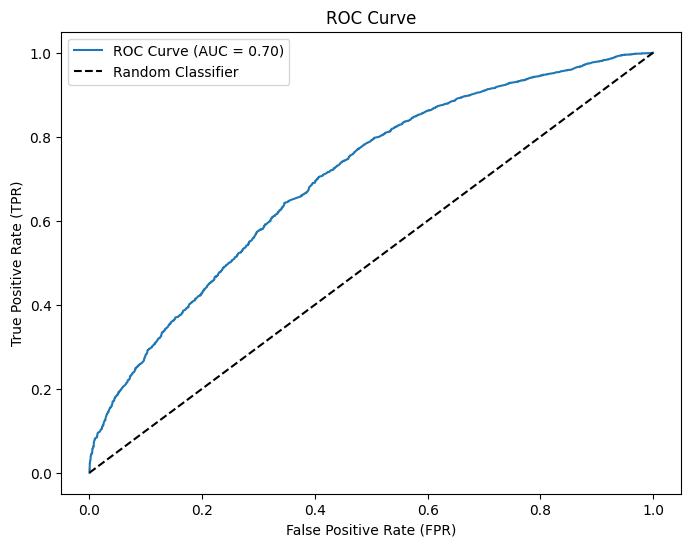

In [41]:
y_true = selected_data['sepsis_icd']
y_pred = selected_data['predicted_sepsis']
y_scores = selected_data['predicted_score']

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

fpr_values, tpr_values, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr_values, tpr_values)

print(f"Confusion Matrix:\n{cm}")
print(f"TPR (Sensitivity): {tpr:.2f}")
print(f"FPR (Fall-out): {fpr:.2f}")
print(f"TNR (Specificity): {tnr:.2f}")
print(f"FNR (Miss Rate): {fnr:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity/TPR): {tpr:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [42]:
rule1 = ctrl.Rule(resp['high'] & bp_systolic['low'], sepsis['yes'])
rule2 = ctrl.Rule(bicarbonate['high'] & heart_rate['low'], sepsis['no'])
rule3 = ctrl.Rule(bp_systolic['high'] & resp['low'], sepsis['no'])
rule4 = ctrl.Rule(bicarbonate['low'] & heart_rate['high'], sepsis['yes'])

In [43]:
sepsis_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
sepsis_simulation = ctrl.ControlSystemSimulation(sepsis_control)

In [44]:
selected_data['predicted_sepsis'] = 0
selected_data['predicted_score'] = 0.0

C:\Users\zgebl\AppData\Local\Temp\ipykernel_8256\2217440563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['predicted_sepsis'] = 0
C:\Users\zgebl\AppData\Local\Temp\ipykernel_8256\2217440563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['predicted_score'] = 0.0


In [45]:
for idx, row in selected_data.iterrows():
    sepsis_simulation.input['resp'] = row['resp']
    sepsis_simulation.input['heart_rate'] = row['heart_rate']
    sepsis_simulation.input['bp_systolic'] = row['bp_systolic']
    sepsis_simulation.input['bicarbonate'] = row['bicarbonate']
    sepsis_simulation.compute()
    selected_data.at[idx, 'predicted_score'] = sepsis_simulation.output.get('sepsis', 0)
    selected_data.at[idx, 'predicted_sepsis'] = 1 if sepsis_simulation.output.get('sepsis', 0) >= 0.5 else 0

predicted_score = sepsis_simulation.output.get('sepsis', 0)


In [46]:
selected_data

,sepsis_icd,sirs,qsofa,resp,heart_rate,bp_systolic,bicarbonate,predicted_sepsis,predicted_score
0,0.0,1.0,0.0,29.0,85.0,122.0,23.0,0,0.463636
1,0.0,1.0,0.0,21.0,88.0,110.0,23.0,1,0.506591
2,0.0,0.0,0.0,20.0,91.0,110.0,23.0,0,0.497122
3,0.0,1.0,0.0,19.0,97.0,114.0,28.0,0,0.465891
4,0.0,1.0,0.0,18.0,99.0,90.0,28.0,0,0.447266
...,...,...,...,...,...,...,...,...,...
10795,1.0,0.0,0.0,15.0,65.0,113.0,18.0,0,0.423240
10796,1.0,0.0,0.0,15.0,63.0,100.0,18.0,0,0.465201
10797,1.0,0.0,0.0,15.0,65.0,99.0,18.0,0,0.468593
10798,1.0,0.0,0.0,20.0,67.0,120.0,18.0,0,0.492655


Confusion Matrix:
[[3803 1448]
 [2322 2926]]
TPR (Sensitivity): 0.56
FPR (Fall-out): 0.28
TNR (Specificity): 0.72
FNR (Miss Rate): 0.44
Accuracy: 0.64
Precision: 0.67
Recall (Sensitivity/TPR): 0.56
F1 Score: 0.61
ROC AUC: 0.69


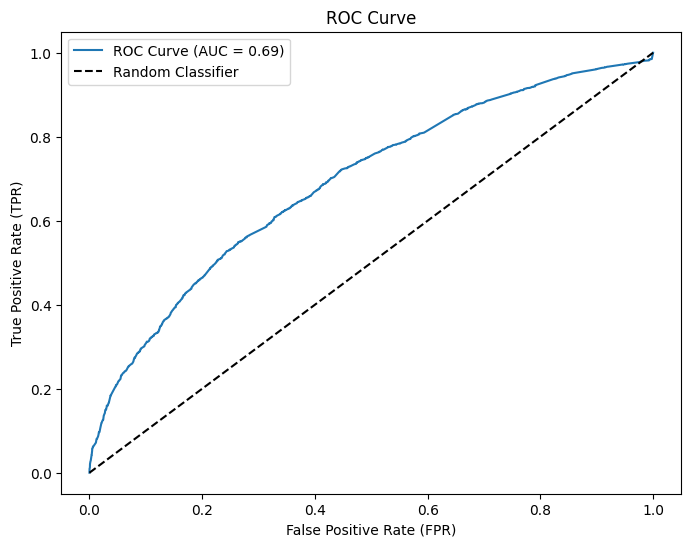

In [47]:
y_true = selected_data['sepsis_icd']
y_pred = selected_data['predicted_sepsis']
y_scores = selected_data['predicted_score']

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

fpr_values, tpr_values, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr_values, tpr_values)

print(f"Confusion Matrix:\n{cm}")
print(f"TPR (Sensitivity): {tpr:.2f}")
print(f"FPR (Fall-out): {fpr:.2f}")
print(f"TNR (Specificity): {tnr:.2f}")
print(f"FNR (Miss Rate): {fnr:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity/TPR): {tpr:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [48]:
rule1 = ctrl.Rule(resp['high'] & bicarbonate['low'], sepsis['yes'])
rule2 = ctrl.Rule(bp_systolic['high'] & heart_rate['low'], sepsis['no'])
rule3 = ctrl.Rule(bp_systolic['low'] & bicarbonate['high'], sepsis['no'])  # because bicarbonate has higher negative correlation
rule4 = ctrl.Rule(bp_systolic['high'] & bicarbonate['low'], sepsis['yes'])
rule5 = ctrl.Rule(resp['low'] & heart_rate['high'], sepsis['no'])  # because resp has higher correlation
rule6 = ctrl.Rule(resp['high'] & heart_rate['low'], sepsis['yes'])

In [49]:
sepsis_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sepsis_simulation = ctrl.ControlSystemSimulation(sepsis_control)

In [50]:
selected_data['predicted_sepsis'] = 0
selected_data['predicted_score'] = 0.0

C:\Users\zgebl\AppData\Local\Temp\ipykernel_8256\2217440563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['predicted_sepsis'] = 0
C:\Users\zgebl\AppData\Local\Temp\ipykernel_8256\2217440563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['predicted_score'] = 0.0


In [51]:
for idx, row in selected_data.iterrows():
    sepsis_simulation.input['resp'] = row['resp']
    sepsis_simulation.input['heart_rate'] = row['heart_rate']
    sepsis_simulation.input['bp_systolic'] = row['bp_systolic']
    sepsis_simulation.input['bicarbonate'] = row['bicarbonate']
    sepsis_simulation.compute()
    selected_data.at[idx, 'predicted_score'] = sepsis_simulation.output.get('sepsis', 0)
    selected_data.at[idx, 'predicted_sepsis'] = 1 if sepsis_simulation.output.get('sepsis', 0) >= 0.5 else 0

predicted_score = sepsis_simulation.output.get('sepsis', 0)


In [52]:
selected_data

,sepsis_icd,sirs,qsofa,resp,heart_rate,bp_systolic,bicarbonate,predicted_sepsis,predicted_score
0,0.0,1.0,0.0,29.0,85.0,122.0,23.0,1,0.507299
1,0.0,1.0,0.0,21.0,88.0,110.0,23.0,1,0.524537
2,0.0,0.0,0.0,20.0,91.0,110.0,23.0,0,0.497122
3,0.0,1.0,0.0,19.0,97.0,114.0,28.0,0,0.469363
4,0.0,1.0,0.0,18.0,99.0,90.0,28.0,0,0.361111
...,...,...,...,...,...,...,...,...,...
10795,1.0,0.0,0.0,15.0,65.0,113.0,18.0,0,0.500000
10796,1.0,0.0,0.0,15.0,63.0,100.0,18.0,1,0.500000
10797,1.0,0.0,0.0,15.0,65.0,99.0,18.0,1,0.500000
10798,1.0,0.0,0.0,20.0,67.0,120.0,18.0,1,0.500000


Confusion Matrix:
[[3065 2186]
 [1918 3330]]
TPR (Sensitivity): 0.63
FPR (Fall-out): 0.42
TNR (Specificity): 0.58
FNR (Miss Rate): 0.37
Accuracy: 0.61
Precision: 0.60
Recall (Sensitivity/TPR): 0.63
F1 Score: 0.62
ROC AUC: 0.65


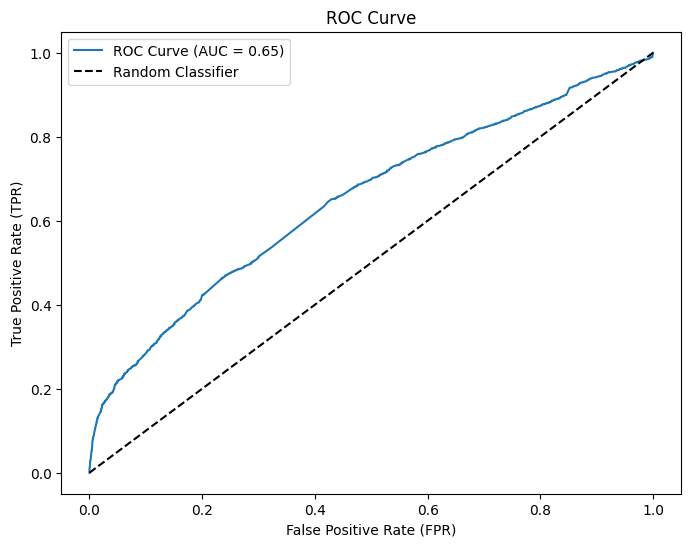

In [53]:
y_true = selected_data['sepsis_icd']
y_pred = selected_data['predicted_sepsis']
y_scores = selected_data['predicted_score']

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

fpr_values, tpr_values, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr_values, tpr_values)

print(f"Confusion Matrix:\n{cm}")
print(f"TPR (Sensitivity): {tpr:.2f}")
print(f"FPR (Fall-out): {fpr:.2f}")
print(f"TNR (Specificity): {tnr:.2f}")
print(f"FNR (Miss Rate): {fnr:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity/TPR): {tpr:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [54]:


rule1 = ctrl.Rule(resp['high'] & bp_systolic['low'], sepsis['yes'])
rule2 = ctrl.Rule(bicarbonate['high'] & heart_rate['low'], sepsis['no'])
rule3 = ctrl.Rule(bp_systolic['low'] & resp['high'], sepsis['yes'])
rule4 = ctrl.Rule(bicarbonate['low'] & heart_rate['high'], sepsis['yes'])
rule5 = ctrl.Rule(bp_systolic['low'] & bicarbonate['high'], sepsis['no'])  # because bicarbonate has higher negative correlation
rule6 = ctrl.Rule(bp_systolic['high'] & bicarbonate['low'], sepsis['yes'])
rule7 = ctrl.Rule(resp['low'] & heart_rate['high'], sepsis['no'])  # because resp has higher correlation
rule8 = ctrl.Rule(resp['high'] & heart_rate['low'], sepsis['yes'])

In [55]:
sepsis_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
sepsis_simulation = ctrl.ControlSystemSimulation(sepsis_control)

In [56]:
selected_data['predicted_sepsis'] = 0
selected_data['predicted_score'] = 0.0

C:\Users\zgebl\AppData\Local\Temp\ipykernel_8256\2217440563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['predicted_sepsis'] = 0
C:\Users\zgebl\AppData\Local\Temp\ipykernel_8256\2217440563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['predicted_score'] = 0.0


In [57]:
for idx, row in selected_data.iterrows():
    sepsis_simulation.input['resp'] = row['resp']
    sepsis_simulation.input['heart_rate'] = row['heart_rate']
    sepsis_simulation.input['bp_systolic'] = row['bp_systolic']
    sepsis_simulation.input['bicarbonate'] = row['bicarbonate']
    sepsis_simulation.compute()
    selected_data.at[idx, 'predicted_score'] = sepsis_simulation.output.get('sepsis', 0)
    selected_data.at[idx, 'predicted_sepsis'] = 1 if sepsis_simulation.output.get('sepsis', 0) >= 0.5 else 0

predicted_score = sepsis_simulation.output.get('sepsis', 0)


In [58]:
selected_data

,sepsis_icd,sirs,qsofa,resp,heart_rate,bp_systolic,bicarbonate,predicted_sepsis,predicted_score
0,0.0,1.0,0.0,29.0,85.0,122.0,23.0,1,0.537037
1,0.0,1.0,0.0,21.0,88.0,110.0,23.0,1,0.524537
2,0.0,0.0,0.0,20.0,91.0,110.0,23.0,0,0.497122
3,0.0,1.0,0.0,19.0,97.0,114.0,28.0,0,0.469363
4,0.0,1.0,0.0,18.0,99.0,90.0,28.0,0,0.361111
...,...,...,...,...,...,...,...,...,...
10795,1.0,0.0,0.0,15.0,65.0,113.0,18.0,1,0.576760
10796,1.0,0.0,0.0,15.0,63.0,100.0,18.0,1,0.534799
10797,1.0,0.0,0.0,15.0,65.0,99.0,18.0,1,0.531407
10798,1.0,0.0,0.0,20.0,67.0,120.0,18.0,1,0.597403


Confusion Matrix:
[[2115 3136]
 [1245 4003]]
TPR (Sensitivity): 0.76
FPR (Fall-out): 0.60
TNR (Specificity): 0.40
FNR (Miss Rate): 0.24
Accuracy: 0.58
Precision: 0.56
Recall (Sensitivity/TPR): 0.76
F1 Score: 0.65
ROC AUC: 0.65


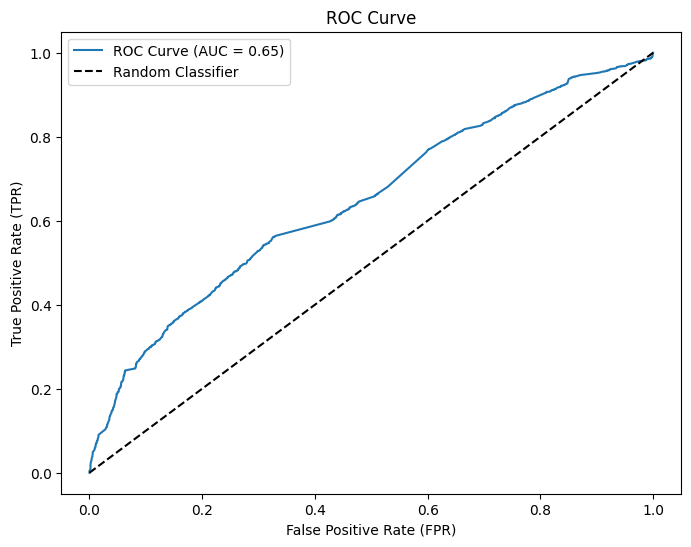

In [59]:
y_true = selected_data['sepsis_icd']
y_pred = selected_data['predicted_sepsis']
y_scores = selected_data['predicted_score']

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

fpr_values, tpr_values, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr_values, tpr_values)

print(f"Confusion Matrix:\n{cm}")
print(f"TPR (Sensitivity): {tpr:.2f}")
print(f"FPR (Fall-out): {fpr:.2f}")
print(f"TNR (Specificity): {tnr:.2f}")
print(f"FNR (Miss Rate): {fnr:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity/TPR): {tpr:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

ORS<br>
Confusion Matrix:
<br>[[3729 1522]
<br> [2319 2929]]
<br>TPR (Sensitivity): 0.56
<br>FPR (Fall-out): 0.29
<br>TNR (Specificity): 0.71
<br>FNR (Miss Rate): 0.44
<br>Accuracy: 0.63
<br>Precision: 0.66
<br>Recall (Sensitivity/TPR): 0.56
<br>F1 Score: 0.60
<br>ROC AUC: 0.70
<br>
REV<br>
Confusion Matrix:
<br>[[3803 1448]
<br> [2322 2926]]
<br>TPR (Sensitivity): 0.56
<br>FPR (Fall-out): 0.28
<br>TNR (Specificity): 0.72
<br>FNR (Miss Rate): 0.44
<br>Accuracy: 0.64
<br>Precision: 0.67
<br>Recall (Sensitivity/TPR): 0.56
<br>F1 Score: 0.61
<br>ROC AUC: 0.69
<br>
THIRD<br>
Confusion Matrix:
<br>[[3065 2186]
<br> [1918 3330]]
<br>TPR (Sensitivity): 0.63
<br>FPR (Fall-out): 0.42
<br>TNR (Specificity): 0.58
<br>FNR (Miss Rate): 0.37
<br>Accuracy: 0.61
<br>Precision: 0.60
<br>Recall (Sensitivity/TPR): 0.63
<br>F1 Score: 0.62
<br>ROC AUC: 0.65

3-4 Combination<br>
Confusion Matrix:
<br>[[2115 3136]
<br> [1245 4003]]
<br>TPR (Sensitivity): 0.76
<br>FPR (Fall-out): 0.60
<br>TNR (Specificity): 0.40
<br>FNR (Miss Rate): 0.24
<br>Accuracy: 0.58
<br>Precision: 0.56
<br>Recall (Sensitivity/TPR): 0.76
<br>F1 Score: 0.65
<br>ROC AUC: 0.65